In [45]:
!nvidia-smi

Mon Apr 19 19:52:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8     8W /  N/A |   1120MiB /  5934MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [47]:
import pickle # 
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
data = pd.read_csv('data/UNSW_NB15_training-set.csv')
data.head()

,id,dur,xProt,xServ,xState,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.121478,4,999,2,6,4,258,172,74.087490,...,1,1,1,0,0,0,1,1,0,0
1,2,0.649902,4,999,2,14,38,734,42014,78.473372,...,1,1,2,0,0,0,1,6,0,0
2,3,1.623129,4,999,2,8,16,364,13186,14.170161,...,1,1,3,0,0,0,2,6,0,0
3,4,1.681642,4,3,2,12,12,628,770,13.677108,...,1,1,3,1,1,0,2,1,0,0
4,5,0.449454,4,999,2,10,6,534,268,33.373826,...,2,1,40,0,0,0,2,39,0,0


In [49]:
X = data.iloc[: , :-1].values
X.shape

(175341, 43)

In [50]:
attacks = list(pd.unique(data["label"]))
attacks

[0, 1]

In [51]:
y = np.array(list(map((lambda x: attacks.index(x)), data.iloc[: , -1].values)))
y.shape

(175341,)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, y_train.shape, y_test.shape

((140272, 43), (140272,), (140272,), (35069,))

In [53]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

------------------------------------------------------------------------------------------------------------------

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [55]:
class UNSW_NB15(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [56]:
train_data = UNSW_NB15(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = UNSW_NB15(torch.Tensor(X_test), torch.Tensor(y_test))

In [57]:
bs = 256

train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=bs)

In [58]:
len(train_loader.dataset)//bs + 1, len(test_loader.dataset)//bs + 1

(548, 137)

In [59]:
class Teacher(nn.Module):

    def __init__(self, n_features, n_classes):
        super(Teacher, self).__init__()

        self.mlp = nn.Sequential(*[
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes)
        ])

    def forward(self, x):
        return self.mlp(x)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [61]:
teacher = Teacher(X_train.shape[1], len(attacks)).to(device)
teacher

Teacher(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [62]:
sum(p.numel() for p in teacher.parameters())

2090

In [63]:
loss_fn = nn.CrossEntropyLoss()
teacher_optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)

In [64]:
def accuracy(preds, labels):
        
    preds = F.softmax(preds, dim=1).argmax(dim=1)
    n_correct = (preds==labels).sum().float()
    
    return (n_correct/len(labels)).item()
    

In [65]:
n_epochs = 50

Epoch 1: Loss = 146.17098604142666, Average epoch accuracy = 0.8727978635443389
Epoch 6: Loss = 57.80532840266824, Average epoch accuracy = 0.9551370514787897
Epoch 11: Loss = 46.836300294846296, Average epoch accuracy = 0.9656820255909523
Epoch 16: Loss = 40.138920821249485, Average epoch accuracy = 0.9708646975294517
Epoch 21: Loss = 35.19070139341056, Average epoch accuracy = 0.9736214074557715
Epoch 26: Loss = 33.77334678545594, Average epoch accuracy = 0.9743513345283313
Epoch 31: Loss = 31.430910730734468, Average epoch accuracy = 0.9760910889310558
Epoch 36: Loss = 30.94527698494494, Average epoch accuracy = 0.9765325617181123
Epoch 41: Loss = 30.163310864940286, Average epoch accuracy = 0.9767606639078934
Epoch 46: Loss = 29.379814010113478, Average epoch accuracy = 0.976966431106094


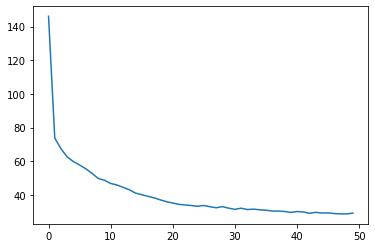

In [66]:
epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        teacher_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        preds = teacher(data)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        teacher_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)

In [67]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = teacher(data)
    accuracies.append(accuracy(preds, labels))
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.9766473622217665


In [68]:
class Student(nn.Module):

    def __init__(self, n_features, n_classes):
        super(Student, self).__init__()

        self.mlp = nn.Sequential(*[
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Linear(16, n_classes)
        ])

    def forward(self, x):
        return self.mlp(x)

In [69]:
student = Student(X_train.shape[1], len(attacks)).to(device)
student

Student(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [70]:
sum(p.numel() for p in student.parameters())

738

In [71]:
student_optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9)

Epoch 1: Loss = 112.61509913951159, Average epoch accuracy = 0.916445692742828
Epoch 6: Loss = 63.817853696644306, Average epoch accuracy = 0.9481818355130454
Epoch 11: Loss = 60.62719889730215, Average epoch accuracy = 0.950974186515286
Epoch 16: Loss = 59.056406162679195, Average epoch accuracy = 0.9520424651185961
Epoch 21: Loss = 57.591807290911674, Average epoch accuracy = 0.9532205178572314
Epoch 26: Loss = 55.89545973390341, Average epoch accuracy = 0.9550738481492022
Epoch 31: Loss = 53.67906726896763, Average epoch accuracy = 0.957566339821711
Epoch 36: Loss = 51.25974849611521, Average epoch accuracy = 0.9603601164408844
Epoch 41: Loss = 49.74092876911163, Average epoch accuracy = 0.962368841371397
Epoch 46: Loss = 48.26836582645774, Average epoch accuracy = 0.9634969967560176


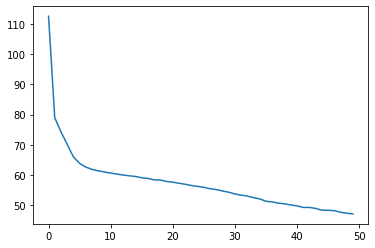

In [72]:
epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        student_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        preds = student(data)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        student_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)

In [73]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = student(data)
    accuracies.append(accuracy(preds, labels))
    
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.9633027080201755


In [77]:
student = Student(X_train.shape[1], len(attacks)).to(device)
student

Student(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [78]:
student_optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9)

Epoch 1: Loss = 50.45177731662989, Average epoch accuracy = 0.9305157961636564
Epoch 6: Loss = 29.23891602270305, Average epoch accuracy = 0.9599210196820489
Epoch 11: Loss = 26.75582654029131, Average epoch accuracy = 0.9634637318170853
Epoch 16: Loss = 24.846191365271807, Average epoch accuracy = 0.9657951262745544
Epoch 21: Loss = 22.87730411440134, Average epoch accuracy = 0.9688388648694449
Epoch 26: Loss = 21.151530525647104, Average epoch accuracy = 0.9709578392496945
Epoch 31: Loss = 20.464964249171317, Average epoch accuracy = 0.9724590367209303
Epoch 36: Loss = 19.87015923857689, Average epoch accuracy = 0.9729532582046342
Epoch 41: Loss = 19.52706876024604, Average epoch accuracy = 0.9732526423287218
Epoch 46: Loss = 19.12944144103676, Average epoch accuracy = 0.9740205862878883


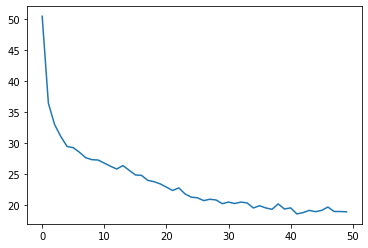

In [79]:
distil_weight = 0.5

epoch_losses = []
epoch_accuracies = []

for e in range(n_epochs):
    running_loss = 0
    batch_accuracies = []
    
    for i, (data, labels) in enumerate(train_loader):
        
        student_optimizer.zero_grad()
        
        data, labels = data.to(device), labels.to(device).long()
        student_preds = student(data)
        loss = (1-distil_weight) * loss_fn(student_preds, labels)
        
        teacher_preds = teacher(data)
        soft_student_probs = F.log_softmax(student_preds/10, dim=1)
        soft_teacher_probs = F.softmax(teacher_preds/10, dim=1)
        loss += distil_weight * F.kl_div(soft_student_probs, soft_teacher_probs.detach(), reduction='batchmean')
        
        loss.backward()
        student_optimizer.step()
        
        running_loss += loss.item()
        batch_accuracies.append(accuracy(student_preds, labels))
        
#         if i%50==0:
#             print(f"Average accuracy = {sum(batch_accuracies)/len(batch_accuracies)}")
    
    epoch_losses.append(running_loss)
    epoch_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
    
    if (e%5 == 0):
        print(f"Epoch {e+1}: Loss = {epoch_losses[e]}, Average epoch accuracy = {epoch_accuracies[e]}")

plt.plot(epoch_losses)

In [80]:
accuracies = []
for data, labels in test_loader:
    
    data, labels = data.to(device), labels.to(device)
    preds = student(data)
    accuracies.append(accuracy(preds, labels))
    
print(f"Average accuracy = {sum(accuracies)/len(accuracies)}")

Average accuracy = 0.9740231728901828


In [81]:
sum(p.numel() for p in student.parameters())

738